# Exercise 1: Infer global numerical diffusivity from globally integrated variance budget
The globally integrated variance budget is given by:
$$ \frac{\partial}{\partial t} \iint \frac{q^2}{2} dA = -\kappa_{num} \iint |\nabla q^2| \,dA$$

We can estimate the tendency term on the LHS using the snapshot diagnostics and the gradient variance term on thr RHS using the mean diagnostics, and solve for $\kappa_{num}$. This is only possible under the assumption that $\kappa_{num}$ is spatially constant.

It is crucial to mask out the fields using the 'hfac' variables. Not doing this resulted in about 1 order of magnitude lower diagnosed diffusivities

In [1]:
import xarray as xr
import numpy as np
from xmitgcm import open_mdsdataset
from xgcm import Grid
from os.path import join as pjoin
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from dask.distributed import Client
client=Client(scheduler_file='/rigel/home/jb3210/scheduler.json')
client

Client Scheduler: tcp://10.43.4.9:8786 Dashboard: http://10.43.4.9:8787,Cluster Workers: 41 Cores: 164 Memory: 492.00 GB


In [3]:
client.restart()

Client Scheduler: tcp://10.43.4.9:8786 Dashboard: http://10.43.4.9:8787,Cluster Workers: 41 Cores: 164 Memory: 492.00 GB


In [15]:
def infer_kappa_from_global_variance_budget(snap, mean, grid, dim=['i', 'j']):
    out = xr.Dataset()
    dt = mean['time'][0]
    q2 = (snap['TRACSQ']/2) * snap['hFacC']
    q2_int = q2.sum(['i', 'j'])
    dq2_dt = q2.diff('time') / dt
    int_dq2_dt = (dq2_dt*snap['rA']).sum(dim)
    
    x_grad = mean['DXSqTr'] * mean['hFacW']
    y_grad = mean['DYSqTr'] * mean['hFacS']
    grad2 = (grid.interp(x_grad, 'X') + grid.interp(y_grad, 'Y'))
    grad2_int = (grad2 * mean['rA']).sum(dim)
    kappa = int_dq2_dt / -grad2_int
    
    out_fields = ['dt', 'q2_int', 'int_dq2_dt', 'grad2_int', 'kappa']
    for of in out_fields:
        out[of] = eval(of)
        
    return out

In [13]:
def convert_trnum2dimension(ds):
    def drop_nonmatching_vars(ds, var_list):
        data_vars = list(ds.data_vars)
        drop_vars = [a for a in data_vars if a not in var_list]
        return ds.drop(drop_vars)
    
    def rename_vars(ds):
        for vv in list(ds.data_vars):
            ds = ds.rename({vv:vv[0:-2]})
        return ds
        
    tr_num = list(set([a[-2:] for a in list(ds.data_vars)]))
    tr_num.sort()
    tr_vars = list(set([a[:-2] for a in list(ds.data_vars)]))
    
    datasets = [drop_nonmatching_vars(ds, [a+n for a in tr_vars]) for n in tr_num]
    datasets = [rename_vars(b) for b in datasets]
    
    tr_num_int = [int(a) for a in tr_num]
    
    tr_dim = xr.DataArray(tr_num_int, 
                          dims='tracer_no',
                          coords={'tracer_no': (['tracer_no', ], tr_num_int)})
    
    ds_combined = xr.concat(datasets,dim='tracer_no')
    ds_combined['tracer_no'] = tr_dim
    
    return ds_combined

In [21]:
ddir = '/rigel/ocp/users/jb3210/projects/aviso_surface_tracer/runs'
timestep = 900 # in seconds
chunksize = 1000
readin_dict = dict(delta_t=timestep, swap_dims=False, chunks={'i':chunksize,'j':chunksize,
                                                              'i_g':chunksize,'j_g':chunksize})

budget_datasets = []
inits = ['PSI', 'LAT', 'SSS', 'SST']
for rr in inits:
    print(rr)
    run = 'run_KOC_%s_variance_budget' %rr
    rundir = pjoin(ddir,run)
    
    ds_mean = convert_trnum2dimension(open_mdsdataset(rundir,prefix=['tracer_diags'],
                                                  **readin_dict)).persist()

    ds_snap = convert_trnum2dimension(open_mdsdataset(rundir,prefix=['tracer_snapshots'],
                                                      **readin_dict)).persist()
    grid = Grid(ds_mean)
    
    # Determine the numerical diffusivity from globally integrated variance budget
    budget_datasets.append(infer_kappa_from_global_variance_budget(ds_snap, ds_mean, grid))
ds_budget = xr.concat(budget_datasets, dim=inits)
ds_budget = ds_budget.rename({'concat_dim':'init'})
ds_budget

PSI


/rigel/home/jb3210/src/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/rigel/home/jb3210/src/xmitgcm/xmitgcm/mds_store.py:220: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


LAT


/rigel/home/jb3210/src/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/rigel/home/jb3210/src/xmitgcm/xmitgcm/mds_store.py:220: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


SSS


/rigel/home/jb3210/src/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/rigel/home/jb3210/src/xmitgcm/xmitgcm/mds_store.py:220: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


SST


/rigel/home/jb3210/src/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/rigel/home/jb3210/src/xmitgcm/xmitgcm/mds_store.py:220: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:     (init: 4, time: 293, tracer_no: 2)
Coordinates:
  * time        (time) int64 0 2592000 5184000 7776000 10368000 12960000 ...
  * tracer_no   (tracer_no) int64 1 2
    iter        (init, time) float64 0.0 2.88e+03 5.76e+03 8.64e+03 ...
  * init        (init) <U3 'PSI' 'LAT' 'SSS' 'SST'
Data variables:
    dt          (init) int64 2592000 2592000 2592000 2592000
    q2_int      (init, tracer_no, time) float64 dask.array<shape=(4, 2, 293), chunksize=(1, 1, 1)>
    int_dq2_dt  (init, tracer_no, time) float64 dask.array<shape=(4, 2, 293), chunksize=(1, 1, 1)>
    grad2_int   (init, tracer_no, time) float64 dask.array<shape=(4, 2, 293), chunksize=(1, 1, 1)>
    kappa       (init, tracer_no, time) float64 dask.array<shape=(4, 2, 293), chunksize=(1, 1, 1)>

In [22]:
ds_budget=ds_budget.compute()

In [23]:
ds_budget

<xarray.Dataset>
Dimensions:     (init: 4, time: 293, tracer_no: 2)
Coordinates:
  * time        (time) int64 0 2592000 5184000 7776000 10368000 12960000 ...
  * tracer_no   (tracer_no) int64 1 2
    iter        (init, time) float64 0.0 2.88e+03 5.76e+03 8.64e+03 ...
  * init        (init) <U3 'PSI' 'LAT' 'SSS' 'SST'
Data variables:
    dt          (init) int64 2592000 2592000 2592000 2592000
    q2_int      (init, tracer_no, time) float64 9.848e+04 9.814e+04 9.73e+04 ...
    int_dq2_dt  (init, tracer_no, time) float64 nan -1.325e+04 -3.672e+04 ...
    grad2_int   (init, tracer_no, time) float64 nan 221.2 514.3 604.6 592.3 ...
    kappa       (init, tracer_no, time) float64 nan 59.91 71.39 76.28 73.99 ...

In [18]:
kappa_dict['SSS']['kappa']

<xarray.DataArray 'kappa' (tracer_no: 2, time: 293)>
dask.array<shape=(2, 293), dtype=float64, chunksize=(1, 1)>
Coordinates:
  * time       (time) int64 0 2592000 5184000 7776000 10368000 12960000 ...
    iter       (time) int64 0 2880 5760 8640 11520 14400 17280 20160 23040 ...
  * tracer_no  (tracer_no) int64 1 2

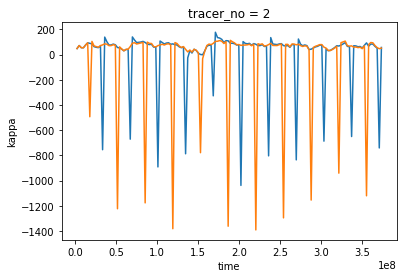

In [19]:
for tt in range(2):
    kappa_dict['SST']['kappa'].isel(tracer_no=tt).plot()

In [31]:
# rr = 'SSS'
# run = 'run_KOC_%s_variance_budget' %rr
# rundir = pjoin(ddir,run)
# ds_snap = convert_trnum2dimension(open_mdsdataset(rundir,prefix=['tracer_snapshots'],
#                                                   **readin_dict)).persist()

# ds_mean = convert_trnum2dimension(open_mdsdataset(rundir,prefix=['tracer_diags'],
#                                               **readin_dict)).persist()

# test = infer_kappa_from_global_variance_budget(ds_snap, ds_mean, grid, dim=['i', 'j'])

# for tt in range(2):
#     test['int_dq2_dt'].isel(tracer_no=tt).plot()

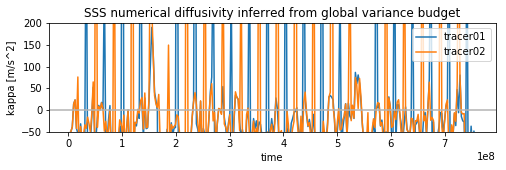

In [8]:
# for ff in list(kappa.keys()):
#     plt.figure(figsize=[8,2])
#     for tt in kappa[ff].tracer_no:
#         kappa[ff].sel(tracer_no=tt).plot()
#     plt.gca().set_ylim([-50,200])
#     plt.axhline(0, color='0.7')
#     plt.ylabel('kappa [m/s^2]')
#     plt.title('%s numerical diffusivity inferred from global variance budget' %ff)
#     plt.legend(['tracer%02i' %a for a in ds_mean.tracer_no.data])

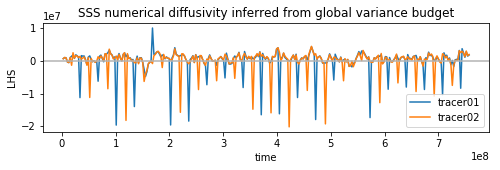

In [9]:
# for ff in list(LHS.keys()):
#     plt.figure(figsize=[8,2])
#     for tt in LHS[ff].tracer_no:
#         LHS[ff].sel(tracer_no=tt).plot()
#     plt.axhline(0, color='0.7')
#     plt.ylabel('LHS')
#     plt.title('%s numerical diffusivity inferred from global variance budget' %ff)
#     plt.legend(['tracer%02i' %a for a in ds_mean.tracer_no.data])

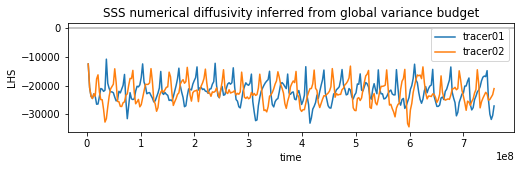

In [10]:
# for ff in list(RHS.keys()):
#     plt.figure(figsize=[8,2])
#     for tt in RHS[ff].tracer_no:
#         RHS[ff].sel(tracer_no=tt).plot()
#     plt.axhline(0, color='0.7')
#     plt.ylabel('LHS')
#     plt.title('%s numerical diffusivity inferred from global variance budget' %ff)
#     plt.legend(['tracer%02i' %a for a in ds_mean.tracer_no.data])